In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Floa

In [2]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7999'})

cluster.scale(jobs=4)
cluster

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://172.22.179.3:7223 Dashboard: /proxy/7999/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
# rdm_idx = pd.date_range(start='2019-09-06 23:58:30', periods=60, tz='UTC', freq='S')  # for P3B

start = '2019-09-06 23:56:30'
end = '2019-09-07 0:04:30'
aircraft = 'P3B'
aircraft2 = 'P3B'

In [5]:
store3 = f"{path_data}/zarr/2DS10_{aircraft2}.zarr"
store4 = f"{path_data}/zarr/HVPS_{aircraft2}.zarr"

In [6]:
xr_2ds = xr.open_zarr(store3)
xr_2ds = xr_2ds.assign(dd=(["diameter"], np.array(xr_2ds.attrs['dsizes'])))

xr_hvps = xr.open_zarr(store4)
xr_hvps = xr_hvps.assign(dd=(["diameter"], np.array(xr_hvps.attrs['dsizes'])))

In [7]:
d_2ds = np.tile(xr_2ds.diameter, [np.shape(xr_2ds.pds.values)[0], 1])
dd_2ds = np.tile(xr_2ds.dd, [np.shape(xr_2ds.pds.values)[0], 1])

In [8]:
d_hvps = np.tile(xr_hvps.diameter, [np.shape(xr_hvps.pds.values)[0], 1])
dd_hvps = np.tile(xr_hvps.dd, [np.shape(xr_hvps.pds.values)[0], 1])

In [9]:
lwc_2ds = (np.pi / (6.  * 1000.)) * (xr_2ds.pds * 1e6) * (d_2ds * 1e-3) ** 3 * (dd_2ds * 1e-3)

In [10]:
lwc_hvps = (np.pi / (6.  * 1000.)) * (xr_hvps.pds * 1e6) * (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3)

Text(0.5, 1.0, '2DS')

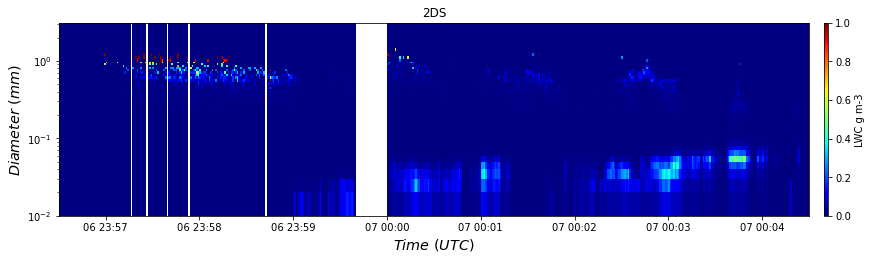

In [12]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)).values, 
                      lwc_2ds.diameter.values * 1e-3, 
                      lwc_2ds.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap='jet')
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_yscale('log')
ax.set_title('2DS')

(0.0, 4.0)

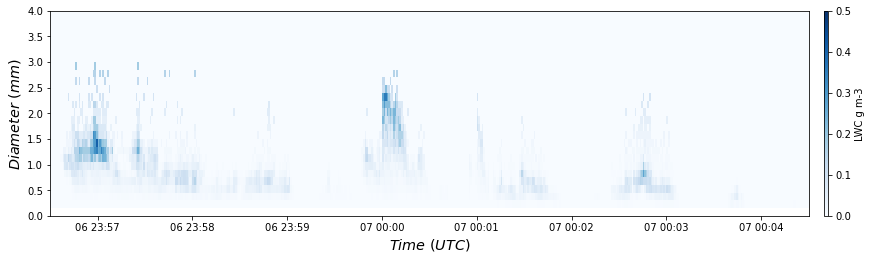

In [16]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)).values, 
                      lwc_hvps.diameter.values * 1e-3, 
                      lwc_hvps.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=0.5, cmap='Blues')
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_ylim(0, 4)

In [42]:
xr_2ds[['pds', 'dd']].sel(time='2019-09-07 0:02:30').sel(diameter=slice(350, 825))

<xarray.Dataset>
Dimensions:   (diameter: 14)
Coordinates:
  * diameter  (diameter) float64 355.0 375.0 395.0 415.0 ... 680.0 730.0 780.0
    time      datetime64[ns] 2019-09-07T00:02:30
Data variables:
    pds       (diameter) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dd        (diameter) float64 20.0 20.0 20.0 20.0 ... 50.0 50.0 50.0 50.0
Attributes:
    aircraft:    P3B
    bin_cent:    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0...
    dsizes:      [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,...
    instrument:  2DS10
    psd_units:   [' #/liter/um']
    sizes:       [5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0, 95.0, ...
    type:        2DS10

In [103]:
def pd_interp(ds):
    ls_d = ds.attrs['sizes'] #.append(ds.attrs['sizes'][-1] + ds.attrs['dsizes'][-1])
    print(ls_d)
    intervals =  pd.IntervalIndex.from_breaks(ls_d)
    df = ds.to_dataframe()
    print(len(intervals))

In [104]:
pd_interp(xr_hvps[['pds', 'dd']].sel(time='2019-09-07 0:02:30').sel(diameter=slice(350, 825)))

[75.0, 225.0, 375.0, 525.0, 675.0, 825.0, 975.0, 1125.0, 1275.0, 1425.0, 1575.0, 1725.0, 1875.0, 2025.0, 2175.0, 2325.0, 2475.0, 2625.0, 2775.0, 2925.0, 3075.0, 3375.0, 3675.0, 3975.0, 4275.0, 4575.0, 4875.0, 5175.0, 5475.0, 5775.0, 6075.0, 6375.0, 6675.0, 6975.0, 7275.0, 7575.0, 8325.0, 9075.0, 9825.0, 10575.0, 11325.0, 12074.0, 12824.0, 13574.0, 14325.0, 15075.0, 16575.0, 18074.0, 19574.0, 21075.0, 22574.0, 24074.0, 25574.0, 27074.0, 28574.0, 30075.0, 33075.0, 36075.0, 39075.0, 42075.0, 45064.0, 45064.0, 48053.0]
62
